In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
train_dir = "dataset/train"
valid_dir = "dataset/validation"
test_dir = "dataset/test"
num_classes = 10

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 837 images belonging to 10 classes.
Found 99 images belonging to 10 classes.
Found 97 images belonging to 10 classes.


In [12]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [14]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

Epoch 1/10
 7/26 [=======>......................] - ETA: 41s - loss: 1.3001 - accuracy: 0.5848

c:\Users\bjwy\anaconda3\envs\tf\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


26/26 [==============================] - 69s 3s/step - loss: 0.6580 - accuracy: 0.7851 - val_loss: 0.2777 - val_accuracy: 0.9167
Epoch 2/10
26/26 [==============================] - 69s 3s/step - loss: 0.1506 - accuracy: 0.9516 - val_loss: 0.1469 - val_accuracy: 0.9688
Epoch 3/10
26/26 [==============================] - 67s 3s/step - loss: 0.0871 - accuracy: 0.9714 - val_loss: 0.1681 - val_accuracy: 0.9583
Epoch 4/10
26/26 [==============================] - 67s 3s/step - loss: 0.0535 - accuracy: 0.9851 - val_loss: 0.2115 - val_accuracy: 0.9792
Epoch 5/10
26/26 [==============================] - 71s 3s/step - loss: 0.0372 - accuracy: 0.9901 - val_loss: 0.2116 - val_accuracy: 0.9688
Epoch 6/10
26/26 [==============================] - 66s 3s/step - loss: 0.0450 - accuracy: 0.9863 - val_loss: 0.1423 - val_accuracy: 0.9583
Epoch 7/10
26/26 [==============================] - 62s 2s/step - loss: 0.0541 - accuracy: 0.9851 - val_loss: 0.3265 - val_accuracy: 0.9583
Epoch 8/10
26/26 [=============

In [17]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.658037,0.785093,0.277728,0.916667
1,0.150594,0.951553,0.146888,0.968750
2,0.087124,0.971429,0.168098,0.958333
3,0.053540,0.985093,0.211537,0.979167
4,0.037173,0.990062,0.211629,0.968750


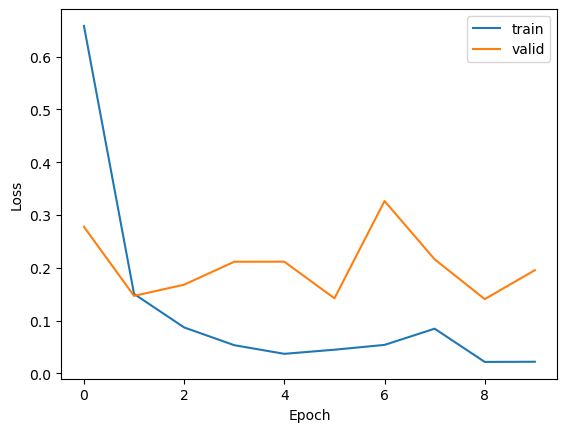

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "valid"])
plt.show()

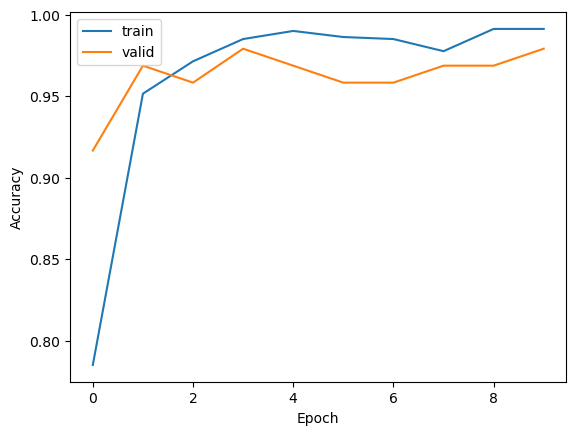

In [19]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "valid"])
plt.show()

In [20]:
preds = model.predict(test_generator)

4/4 [==============================] - 8s 2s/step


In [21]:
y_pred = np.argmax(preds, axis=1)

In [22]:
for k, v in test_generator.class_indices.items():
    print(v, ":", k)

0 : apple
1 : banana
2 : grapes
3 : kiwi
4 : mango
5 : orange
6 : pear
7 : pineapple
8 : pomegranate
9 : watermelon


In [23]:
pred_classes = {
    0 : "apple",
    1 : "banana",
    2 : "grapes",
    3 : "kiwi",
    4 : "mango",
    5 : "orange",
    6 : "pear",
    7 : "pineapple",
    8 : "pomegranate",
    9 : "watermelon"
}

In [24]:
y_pred = list(map(lambda x: pred_classes[x], y_pred))

In [25]:
y_test = list(map(lambda x: pred_classes[x], test_generator.classes))

In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_test))

ModuleNotFoundError: No module named 'sklearn'